[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PTB-MR/mrpro/blob/main/examples/notebooks/qmri_sg_challenge_2024_t1.ipynb) [![Download notebook](https://img.shields.io/badge/Download-notebook-blue?logo=jupyter)](path:qmri_sg_challenge_2024_t1.ipynb)

In [1]:
import importlib

if not importlib.util.find_spec('mrpro'):
    %pip install mrpro[notebooks]

# QMRI Challenge ISMRM 2024 - $T_1$ mapping
In the 2024 ISMRM QMRI Challenge, the goal is to estimate $T_1$ maps from a set of inversion recovery images.
The dataset consists of images obtained at 10 different inversion times using a turbo spin echo sequence. Each
inversion time is saved in a separate DICOM file. In order to obtain a $T_1$ map, we are going to:
- download the data from Zenodo
- read in the DICOM files (one for each inversion time) and combine them in an IData object
- define a signal model and data loss (mean-squared error) function
- find good starting values for each pixel
- carry out a fit using ADAM from PyTorch

### Get data from Zenodo

In [2]:
import tempfile
import zipfile
from pathlib import Path

import zenodo_get

dataset = '10868350'

tmp = tempfile.TemporaryDirectory()  # RAII, automatically cleaned up
data_folder = Path(tmp.name)
zenodo_get.zenodo_get([dataset, '-r', 5, '-o', data_folder])  # r: retries
with zipfile.ZipFile(data_folder / Path('T1 IR.zip'), 'r') as zip_ref:
    zip_ref.extractall(data_folder)

Title: Quantitative Study Group: T_1
Keywords: 
Publication date: 2024-03-25
DOI: 10.5281/zenodo.10868350
Total size: 412.6 kB

Link: https://zenodo.org/records/10868350/files/T1 IR.zip   size: 412.6 kB



Checksum is correct. (ccd5f719680c4b5396ec5fb0932f66e1)
All files have been downloaded.


### Create image data (IData) object with different inversion times
We read in the DICOM files and combine them in an `~mrpro.data.IData` object.
The inversion times are stored in the DICOM files are available in the header of the `~mrpro.data.IData` object.

In [3]:
import mrpro

ti_dicom_files = data_folder.glob('**/*.dcm')
idata_multi_ti = mrpro.data.IData.from_dicom_files(ti_dicom_files)

if idata_multi_ti.header.ti is None:
    raise ValueError('Inversion times need to be defined in the DICOM files.')

In [4]:
import matplotlib.pyplot as plt
import torch


def show_images(*images: torch.Tensor, titles: list[str] | None = None) -> None:
    """Plot images."""
    n_images = len(images)
    _, axes = plt.subplots(1, n_images, squeeze=False, figsize=(n_images * 3, 3))
    for i in range(n_images):
        axes[0][i].imshow(images[i], cmap='gray')
        axes[0][i].axis('off')
        if titles:
            axes[0][i].set_title(titles[i])
    plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


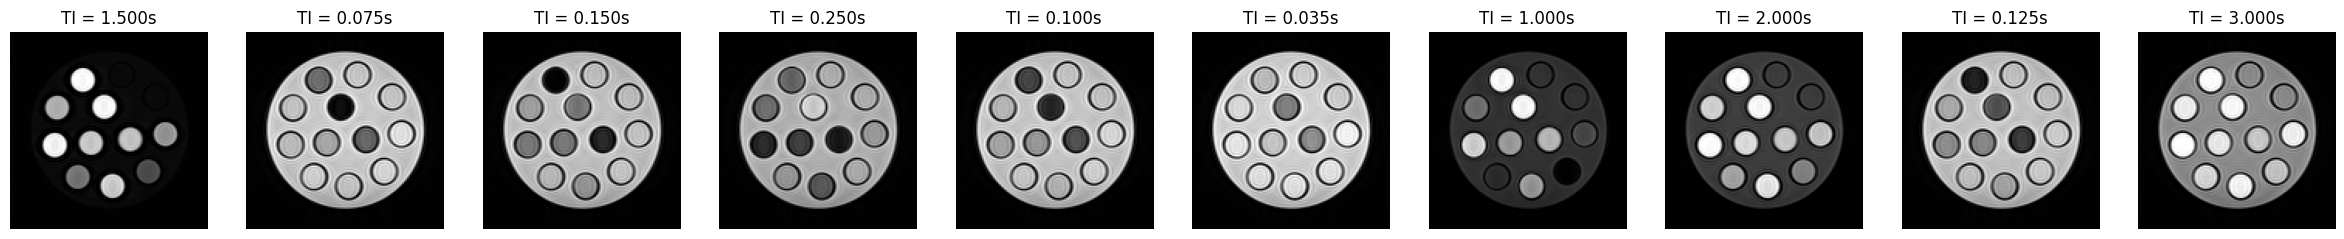

In [5]:
# Let's have a look at some of the images
show_images(
    *idata_multi_ti.data[:, 0, 0].abs(),
    titles=[f'TI = {ti:.3f}s' for ti in idata_multi_ti.header.ti],
)

### Signal model and loss function
We use the model $q$

$q(TI) = M_0 (1 - e^{-TI/T_1})$

with the equilibrium magnetization $M_0$, the inversion time $TI$, and $T_1$. We have to keep in mind that the DICOM
images only contain the magnitude of the signal. Therefore, we need $|q(TI)|$:

In [6]:
model = mrpro.operators.MagnitudeOp() @ mrpro.operators.models.InversionRecovery(ti=idata_multi_ti.header.ti)

As a loss function for the optimizer, we calculate the mean-squared error between the image data $x$ and our signal
model $q$.

In [7]:
mse = mrpro.operators.functionals.MSE(idata_multi_ti.data.abs())

Now we can simply combine the two into a functional to solve

$ \min_{M_0, T_1} \big| |q(M_0, T_1, TI)| - x\big|_2^2$

In [8]:
functional = mse @ model

### Starting values for the fit
We are trying to minimize a non-linear function $q$. There is no guarantee that we reach the global minimum, but we
can end up in a local minimum.

To increase our chances of reaching the global minimum, we can ensure that our starting
values are already close to the global minimum. We need a good starting point for each pixel.

One option to get a good starting point is to calculate the signal curves for a range of $T_1$ values and then check
for each pixel which of these signal curves fits best. This is similar to what is done for MR Fingerprinting. So we
are going to:
- define a list of realistic $T_1$ values (we call this a dictionary of $T_1$ values)
- calculate the signal curves corresponding to each of these $T_1$ values
- compare the signal curves to the signals of each voxel (we use the maximum of the dot-product as a metric of how
well the signals fit to each other)
- use the $T_1$ value with the best fit as a starting value for the fit. Use the scaling factor of the best fit for
the $M_0$ value.

This is implemented in the `~mrpro.operators.DictionaryMatchOp` operator.

In [9]:
# Define 100 T1 values between 0.1 and 3.0 s
t1_values = torch.linspace(0.1, 3.0, 100)
# Create the dictionary. We set M0 to constant 1, as the scaling is handled by the dictionary matching operator.
dictionary = mrpro.operators.DictionaryMatchOp(model, 0).append(torch.ones(1), t1_values)
# Select the closest values in the dictionary for each voxel based on cosine similarity
m0_start, t1_start = dictionary(idata_multi_ti.data.real)

#### Visualize the starting values
Let's have a look at the starting values for $M_0$ and $T_1$:

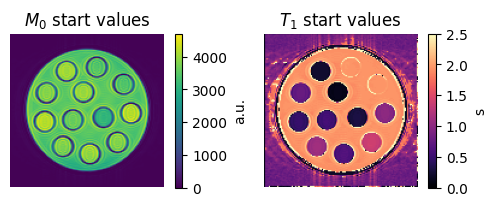

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(6, 2), squeeze=False)

im = axes[0, 0].imshow(m0_start[0, 0])
axes[0, 0].set_title('$M_0$ start values')
axes[0, 0].set_axis_off()
fig.colorbar(im, ax=axes[0, 0], label='a.u.')

im = axes[0, 1].imshow(t1_start[0, 0], vmin=0, vmax=2.5, cmap='magma')
axes[0, 1].set_title('$T_1$ start values')
axes[0, 1].set_axis_off()
fig.colorbar(im, ax=axes[0, 1], label='s')

plt.show()

### Carry out fit
We are now ready to carry out the fit. We are going to use the `~mrpro.algorithms.optimizers.adam` optimizer.
If there is a GPU available, we can use it by moving both the data and the model to the GPU.

In [11]:
# Move initial values and model to GPU if available
if torch.cuda.is_available():
    print('Using GPU')
    functional.cuda()
    m0_start = m0_start.cuda()
    t1_start = t1_start.cuda()

# Hyperparameters for optimizer
max_iterations = 2000
learning_rate = 1e-1

# Run optimization
result = mrpro.algorithms.optimizers.adam(
    functional, [m0_start, t1_start], max_iterations=max_iterations, learning_rate=learning_rate
)
m0, t1 = (p.detach().cpu() for p in result)
model.cpu()

OperatorComposition(
  (_operator1): MagnitudeOp()
  (_operator2): InversionRecovery()
)

### Visualize the final results

To get an impression of how well the fit has worked, we are going to calculate the relative error between

$E_\text{relative} = \sum_{TI}\frac{|(q(M_0, T_1, TI) - x)|}{|x|}$

on a voxel-by-voxel basis
We also mask out the background by thresholding on $M_0$.

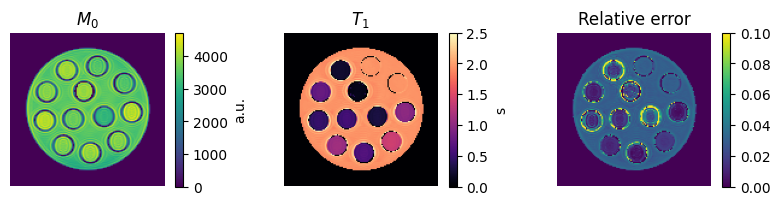

In [12]:
error = model(m0, t1)[0] - idata_multi_ti.data
relative_absolute_error = error.abs().sum(dim=0) / (idata_multi_ti.data.abs().sum(dim=0) + 1e-9)

mask = torch.isnan(t1) | (m0 < 500)
m0[mask] = 0
t1[mask] = 0
relative_absolute_error[mask] = 0

fig, axes = plt.subplots(1, 3, figsize=(10, 2), squeeze=False)
im = axes[0, 0].imshow(m0[0, 0])
axes[0, 0].set_title('$M_0$')
axes[0, 0].set_axis_off()
fig.colorbar(im, ax=axes[0, 0], label='a.u.')

im = axes[0, 1].imshow(t1[0, 0], vmin=0, vmax=2.5, cmap='magma')
axes[0, 1].set_title('$T_1$')
axes[0, 1].set_axis_off()
fig.colorbar(im, ax=axes[0, 1], label='s')

im = axes[0, 2].imshow(relative_absolute_error[0, 0], vmin=0, vmax=0.1)
axes[0, 2].set_title('Relative error')
axes[0, 2].set_axis_off()
fig.colorbar(im, ax=axes[0, 2])

plt.show()

### Next steps

The 2024 ISMRM QMRI Challenge also included the estimation of $T_2^*$ maps from multi-echo data. You can find the
the data on zenodo in [record 10868361](https://zenodo.org/record/10868361) as ``T2star.zip``
You can download and unpack it using the same method as above.

As a signal model $q$ you can use `~mrpro.operators.models.MonoExponentialDecay` describing the signal decay
as $q(TE) = M_0 e^{-TE/T_2^*}$ with the equilibrium magnetization $M_0$, the echo time $TE$, and $T_2^*$.\
Give it a try and see if you can obtain good $T_2^*$ maps!
```{note}
The echo times $TE$ can be found in `IData.header.te`. As starting values, either dictionary matching, or
the signal at the shortest echo time for $M_0$ and 20 ms for $T_2^*$ can be used.
```